In [298]:
%pylab inline

import matlab.engine
import matlab
import networkx as nx
import scipy.sparse
import pandas as pd
from itertools import product
from scipy.io import loadmat
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.datasets.base import Bunch
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import empirical_covariance
from sklearn.model_selection import GridSearchCV, ShuffleSplit

from regain import datasets; reload(datasets)
from regain.datasets import is_pos_def, is_pos_semidef
from regain.plot import plot_graph_with_latent_variables
from regain.admm import time_graph_lasso_; reload(time_graph_lasso_);
from regain.admm import latent_time_graph_lasso_; reload(latent_time_graph_lasso_)
from regain.admm import latent_graph_lasso_; reload(latent_graph_lasso_);
from regain import model_selection; reload(model_selection)
from regain import utils; reload(utils)
import time

Populating the interactive namespace from numpy and matplotlib


# Performances of the different algorithms

In [292]:
def ltgl_results(data_grid, dataframe, K, K_obs, ells, **params):
    
    mdl = latent_time_graph_lasso_.LatentTimeGraphLasso(
        eta=1000,
        bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
        max_iter=500, rho=1./ np.sqrt(np.array(data_list).shape[1]))
    
    tic = time.time()
    ll = mdl.set_params(**params).fit(data_grid)
    tac = time.time()
    iterations = ll.n_iter_
    F1score = utils.structure_error(K, ll.precision_)['f1']
    MSE_observed = utils.error_norm(K_obs, ll.precision_ - ll.latent_)
    MSE_precision = utils.error_norm(K, ll.precision_)
    MSE_latent = utils.error_norm(ells, ll.latent_)
    mean_rank_error = utils.error_rank(ells, ll.latent_)
    
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=ll)
    return res

In [5]:
import sys
sys.path.append("/home/fede/src/TVGL/")
import TVGL; reload(TVGL)
import inferGraphL2; reload(inferGraphL2)
from TVGL import tvgl_hallac

def hallac_results(data_grid, dataframe, K, K_obs, ells, beta, alpha):
    tic = time.time()
    thetaSet, empCovSet, status, gvx = tvgl_hallac(
        data_grid.transpose(2,0,1), lamb=alpha, beta=beta, indexOfPenalty=2)
    tac = time.time()

    if status != "Optimal":
        print "not converged"
    precisions = np.array(thetaSet)
    F1score = utils.structure_error(K, precisions)['f1']
    MSE_observed = None
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = None
    mean_rank_error = None

    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=gvx.n_iter_,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=status,
               estimator=gvx)

    return res

In [293]:
from sklearn.covariance import GraphLasso
def glasso_results(data_grid, dataframe, K, K_obs, ells, alpha):
    gl = GraphLasso(alpha=alpha, mode='cd', assume_centered=False)
    
    tic = time.time()
    iters = []
    precisions = []
    for d in data_grid.transpose(2,0,1):
        gl.fit(d)
        iters.append(gl.n_iter_)
        precisions.append(gl.precision_)
    tac = time.time()
    iterations = np.max(iters)
    precisions = np.array(precisions)
    F1score = utils.structure_error(K, precisions)['f1']
    MSE_observed = None
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = None
    mean_rank_error = None
 
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=gl)
 
    return res

In [294]:
def chandresekeran_results(data_grid, dataframe, K, K_obs, ells, tau, alpha):
   
    emp_list = np.array([empirical_covariance(x, assume_centered=True)
                        for x in data_grid.transpose(2,0,1)]).transpose(1,2,0)
    
    n_samples = emp_list.shape[0]
    opts = dict(continuation=1, num_continuation=0,eta=np.sqrt(100),muf=1e-6,
                maxiter=500,stoptol=1e-5,over_relax_par=1, mu=n_samples)
#     start_time = time.time()

    # 1. SCIPY
    # from scipy.io import loadmat, savemat
    # savemat("/home/fede/Desktop/details.mat", {'emp_list':emp_list, 'tau':taus[-1], 'alpha':alphas[-1]})
    # loadmat("/home/fede/Desktop/output.mat")
    
    # 2. pymatbridge
    # mlab = Matlab()
    # mlab.start()

    # # single run of ADMM_B
    # # result = mlab.run_func('/home/fede/Downloads/lvglasso-pub/ADMM_B.m', emp_list[...,0], alpha, tau, opts)

    # # insert the ADMM_B.m function in the path
    # mlab.run_code("addpath(genpath('/home/fede/Downloads/lvglasso-pub/'))")

    # result = mlab.run_func("/home/fede/src/slipguru/regain/regain/wrapper/ADMMMA.m",
    #                       emp_list, alpha, tau)
    # mlab.stop()
    # ma_output = Bunch(**result['result'])
    
    # 3. Matlab engine
    eng = matlab.engine.start_matlab()

    eng.addpath(r'/home/fede/Downloads/lvglasso-pub/',nargout=0)
    eng.addpath(r'/home/fede/src/slipguru/regain/regain/wrapper/',nargout=0)
    result = eng.ADMMMA(matlab.double(emp_list.tolist()),float(alpha),float(tau))
    eng.quit()    
    ma_output = Bunch(**result)

    ma_output.R = np.array(ma_output.R)
    ma_output.S = np.array(ma_output.S)
    ma_output.L = np.array(ma_output.L)
    
    F1score = utils.structure_error(K, ma_output.R + ma_output.L)['f1']
    MSE_observed = utils.error_norm(K_obs, ma_output.R)
    MSE_precision = utils.error_norm(K, ma_output.R + ma_output.L)
    MSE_latent = utils.error_norm(ells, ma_output.L)
    mean_rank_error = utils.error_rank(ells, ma_output.L)
    
    res = dict(n_dim_obs=K.shape[1],
               time=ma_output.elapsed_time,
               iterations=np.max(ma_output.iter),
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None, estimator=ma_output)
 
    return res

# Run experiments

### Prepare datasets

In [310]:
n_dims = np.sqrt(np.logspace(2,5,10)).astype(int)
n_times = [20,50,100]

In [312]:
n_samples = 1000
n_dim_lat = 3

np.random.seed(42)
data = {(dim,T) : datasets.generate_dataset(
    mode='fixed', n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=dim,  T=T, epsilon=1e-2)
    for dim, T in product(n_dims, n_times)}

### Cross validate

In [315]:
def cross_validate(data_grid, model='bo', **kwargs):
    mdl = latent_time_graph_lasso_.LatentTimeGraphLasso(
        eta=1000,
        bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
        max_iter=250, rho=1./ np.sqrt(np.array(data_list).shape[1]))
    
    if model == 'gs':
        ltgl = GridSearchCV(mdl, kwargs['param_grid'], cv=ShuffleSplit(3, test_size=.5), verbose=True)
    else:
        domain = [
            {'name': 'tau', 'type': 'continuous', 'domain': (-1, 0)},
            {'name': 'alpha', 'type': 'continuous', 'domain': (-2.,np.log10(.5))},
            {'name': 'beta', 'type': 'continuous', 'domain': (-2.,np.log10(.5))},
            # {'name': 'eta', 'type': 'continuous', 'domain': (-2.,np.log10(.5))},
        ]
        ltgl = model_selection.BayesianOptimization(
            mdl, domain=domain, n_jobs=2, acquisition_weight=1, acquisition_jitter=.01,
            acquisition_type='EI', max_iter=300)

    ltgl.fit(data_grid)
    return ltgl.best_params_

In [316]:
best_params_ = {}
for k, res in data.items():
    print("CV start with: dim=%d, T=%d" % k)
    data_grid = np.array(res.data).transpose(1,2,0)  # to use it later for grid search
    best_params_[k] = cross_validate(data_grid)

CV start with: dim=100, T=100
CV start with: dim=31, T=50
CV start with: dim=46, T=100
CV start with: dim=14, T=50
CV start with: dim=215, T=20
CV start with: dim=316, T=100
CV start with: dim=68, T=20
CV start with: dim=215, T=100
CV start with: dim=21, T=20
CV start with: dim=10, T=100
CV start with: dim=14, T=100
CV start with: dim=146, T=100
CV start with: dim=21, T=100
CV start with: dim=100, T=50
CV start with: dim=100, T=20
CV start with: dim=146, T=20
CV start with: dim=316, T=50
CV start with: dim=68, T=100
CV start with: dim=10, T=50
CV start with: dim=146, T=50
CV start with: dim=14, T=20
CV start with: dim=215, T=50
CV start with: dim=31, T=100
CV start with: dim=46, T=50
CV start with: dim=316, T=20
CV start with: dim=10, T=20
CV start with: dim=68, T=50
CV start with: dim=31, T=20
CV start with: dim=46, T=20
CV start with: dim=21, T=50


### Comparison

In [289]:
# prepare dataframe for results
cols = pd.MultiIndex.from_product([["F1score", "MSE_precision", "MSE_observed",
                             "MSE_latent","mean_rank_error"], n_dims], names=('score','dims'))
rows = pd.MultiIndex.from_product([['ours', 'friedman', 'chandresekeran', 'hallac'], n_times],
                                  names=('method','time'))

dff = pd.DataFrame(columns=cols, index=rows)

In [282]:
taus, betas, alphas = [], [], []
for k, res in data_dict.items():
    print("Start with: dim=%d, T=%d" % k)
    data_list = res.data
    K = res.thetas
    K_obs = res.thetas_observed
    ells = res.ells
    data_grid = np.array(data_list).transpose(1,2,0)  # to use it later for grid search

    print("Cross Validating parameters ...")
    ours, alpha, tau, beta, eta = ltgl_results(data_grid, ours, K, K_obs, ells)
    taus.append(tau)
    alphas.append(alpha)
    betas.append(beta)
    
    print("starting Graph Lasso")
    friedman = glasso_results(data_grid, friedman,  K, K_obs, ells, alpha=alphas[-1])
    print("starting hallac")
    hallac = hallac_results(data_grid, hallac, K, K_obs, ells, beta=betas[-1], alpha=alphas[-1])
    print("starting chandresekeran")
    chandresekeran = chandresekeran_results(data_grid, chandresekeran, K, K_obs, ells, taus[-1], alphas[-1])

Start with: dim=10, T=100


# Results chandresekeran

In [ ]:
emps = []
for d in data:
    emp_list = np.array([empirical_covariance(x, assume_centered=True)
                        for x in d.transpose(2,0,1)])
    emps.append(emp_list)

In [235]:
from itertools import product

In [272]:
dff.xs('F1score', level='score', axis=1)

dims                     10         100         500         1000
method         time                                             
ours           10    0.273632   0.080524    0.188551    0.331259
               100        NaN        NaN         NaN         NaN
               500        NaN        NaN         NaN         NaN
               1000       NaN        NaN         NaN         NaN
friedman       10    0.218284  0.0355886   0.0104483  0.00702803
               100        NaN        NaN         NaN         NaN
               500        NaN        NaN         NaN         NaN
               1000       NaN        NaN         NaN         NaN
chandresekeran 10    0.208861  0.0258728  0.00520714   0.0026235
               100        NaN        NaN         NaN         NaN
               500        NaN        NaN         NaN         NaN
               1000       NaN        NaN         NaN         NaN
hallac         10    0.278215  0.0680848   0.0402926   0.0436957
               100        NaN        NaN         NaN         NaN
               500        NaN        NaN         NaN         NaN
               1000       NaN        NaN         NaN         NaN

In [258]:
for ff in ['ours', 'friedman', 'chandresekeran', 'hallac']:
    arr = locals()[ff]
    dff.loc[(ff, 10)] = pd.Series(({(col,dim): arr[arr['n_dim_obs'] == dim].iloc[0][col] for (dim,col) in product(
        arr['n_dim_obs'].unique(),
        ["F1score", "MSE_precision", "MSE_observed","MSE_latent","mean_rank_error"])}))
#     dff = dff.append(pd.Series(({(col,dim): arr[arr['n_dim_obs'] == dim].iloc[0][col] for (dim,col) in product(
#         arr['n_dim_obs'].unique(),
#         ["F1score", "MSE_precision", "MSE_observed","MSE_latent","mean_rank_error"])}), name=(ff, 10)))

In [163]:
dff.T.to_latex("arr.tex", float_format='%.2f', na_rep='-')

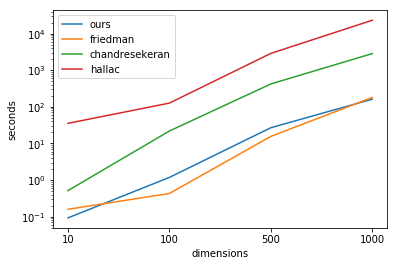

In [178]:
for ff in ['ours', 'friedman', 'chandresekeran', 'hallac']:
    arr = locals()[ff]
    plt.plot(arr.time, label=ff)
plt.yscale('log')
plt.xlabel("dimensions")
plt.ylabel("seconds")
plt.xticks(range(4), ours.n_dim_obs)
plt.legend()
plt.savefig("/home/fede/Dropbox/Latent variables networks/paper formatted/speedup.pdf")

In [204]:
new_index = list(product(list(dff.columns.levels[1]), list(dff.columns.levels[0])))

In [206]:
dff

10                                          \
                 F1score MSE_precision MSE_observed MSE_latent   
ours            0.273632      0.056111     0.075903   0.013877   
friedman        0.218284      0.189795          NaN        NaN   
chandresekeran  0.208861      0.162082     0.191472   0.013877   
hallac          0.278215      0.066254          NaN        NaN   

                                    100                              \
               mean_rank_error   F1score MSE_precision MSE_observed   
ours                       3.0  0.080524      0.703623     0.731838   
friedman                   NaN  0.035589      5.365712          NaN   
chandresekeran             3.0  0.025873      4.746459     4.767921   
hallac                     NaN  0.068085      0.681850          NaN   

                                               500                 \
               MSE_latent mean_rank_error   F1score MSE_precision   
ours             0.074382             2.2  0.188551      4.235165   
friedman              NaN             NaN  0.010448     51.868782   
chandresekeran   0.074208             3.0  0.005207    112.342229   
hallac                NaN             NaN  0.040293      6.119983   

                                                            1000  \
               MSE_observed MSE_latent mean_rank_error   F1score   
ours               7.681046   3.818787           -94.2  0.331259   
friedman                NaN        NaN             NaN  0.007028   
chandresekeran   120.965549  29.102894           -44.4  0.002623   
hallac                  NaN        NaN             NaN  0.043696   

                                                                      
               MSE_precision MSE_observed MSE_latent mean_rank_error  
ours               15.305459    34.767569  31.485137          -259.7  
friedman          123.489266          NaN        NaN             NaN  
chandresekeran    948.354074   948.693877   4.129073             0.3  
hallac             11.318067          NaN        NaN             NaN